# Symbolic calculations

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections.abc import Callable
import sympy
from  sympy import *
init_printing(use_unicode=False, wrap_line=False)

## Analytical formulas

The Hull-White Model

(see Damiano Brigo and Fabio Mercurio "Interest Rate Models Theory and Practice")

$$
\text{d}r(t) = \left[\theta(t)-a r(t)\right] \text{d}t + \sigma \text{d}W(t)
$$
With market-observable discount factors (zero-coupon bonds) $P(0,t)$:
\begin{eqnarray}
f(0,T) &=& -\frac{\partial \text{ln} P(0,T)}{\partial T}
\\
\theta(t) &=& \frac{\partial{f(0,t)}}{\partial t} + a f(0,t) + \frac{\sigma^2}{2a}(1-e^{-2 a t})
\end{eqnarray}

In [2]:
class HullWhiteAnalytical:

    def __init__ (self):
        self.t, self.T, self.sigma, self.a = symbols('t T sigma a', real = True, positive = True)
        self.r = symbols('r', real = True)
        self.P0_t = exp(-self.r*self.t)
    
    def P0 (self, t):
        return self.P0_t.subs(self.t,t)
    
    def f0 (self):
        return diff(-log(self.P0(self.t)),self.t)
    
    def r0 (self):
        return self.f0().subs(self.t,0)
    
    def alpha (self):
        return self.f0() + self.sigma**2/(2*self.a**2) * (1-exp(-self.a*self.t))**2
    
    def r_mean (self):
        alpha_t = self.alpha()
        alpha_0 = alpha_t.subs(self.t,0)
        return exp(-self.a*self.t)*(self.r0()-alpha_0) + alpha_t
    
    def r_variance (self):
        return self.sigma**2/(2*self.a) * (1-exp(-2*self.a*self.t))
    
    def theta (self):
        z1 = diff(self.f0(),self.t)
        z2 = self.a*self.f0()
        z3 = self.sigma**2/(2*self.a)*(1-exp(-2*self.a*self.t))
        return z1+z2+z3
    
    def theta_lambdify (self):
        return lambdify([self.a,self.sigma,self.r,self.t],self.theta())
        
    def A (self):
        e1 = self.P0(self.T)/self.P0(self.t)
        e2 = self.B() * self.f0()
        e3 = self.sigma**2/(4*self.a) * (1-exp(-2*self.a*self.t)) * self.B()**2
        return e1*exp(e2-e3)

    def B (self):
        return (1 - exp(-self.a*(self.T-self.t))) / self.a

    def P (self):
        return self.A() * exp(-self.B()*self.r0())

    def P_lambdify (self):
        return lambdify([self.a,self.sigma,self.r,self.t],self.P())

In [3]:
hw1 = HullWhiteAnalytical()
#hw1.P0_t = exp(-hw1.r*hw1.t - hw1.r*hw1.t**2)
hw1.P0(hw1.t)

In [4]:
hw1.r0()

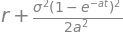

In [5]:
hw1.alpha()

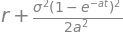

In [6]:
hw1.r_mean()

In [7]:
hw1.r_variance()

In [8]:
hw1.theta()

In [9]:
hw1.B()

In [10]:
hw1.A()

In [11]:
hw1.P()

# Monte Carlo

- define parameters $a$ and $\sigma$
- define $P(0,t)$ function
- compute $\theta(t)$
- 

In [12]:
from init import *
from plot import plot
from viz import viz

server = 'http://az.hopto.org:8010'

In [13]:
TimeStart = 0 
TimeHorizon = 10
theta_points = 10
a = 1e-2
sigma = 2e-2
rfree = 5e-2
hwmc = HullWhiteAnalytical()
hwmc.P0_t = exp(-hwmc.r*hwmc.t)
theta = hwmc.theta_lambdify()
dt = (TimeHorizon-TimeStart) / (theta_points-1)
theta_y = [theta(a,sigma,rfree,TimeStart+dt*i) for i in range(theta_points)]
theta_y

In [14]:
def create_hw_mc_model (
    a:float,
    sigma:float,
    rfree:float,
    TimeStart    = 0,
    TimeHorizon  = 10,
    TimeSteps    = 100,
    NumPaths     = 100000,
    theta_points = 100
):

    # Create a model, save input parameters

    model = sdk.Model()

    model.TimeStart = TimeStart
    model.TimeSteps = TimeSteps
    model.NumPaths = NumPaths

    model.T = [TimeHorizon/2, TimeHorizon]
    
    model.a_const = a
    model.sigma_const = sigma
    model.rfree_const = rfree
    model.TimeHorizon = TimeHorizon

    # Create the hw-analytical solution
    # to calculate the theta(t) function
    
    model.hw_analytical = HullWhiteAnalytical()
    hwmc = model.hw_analytical
    hwmc.P0_t = exp(-hwmc.r*hwmc.t)
    assert hwmc.r0().subs(hwmc.r,rfree) == rfree

    # Compute theta(t)
    # Create points for linear interpolation of theta(t)
    
    assert theta_points >= 2
    theta = hwmc.theta_lambdify()
    dt = (TimeHorizon-TimeStart) / (theta_points-1)
    model.theta_t = [TimeStart+dt*i for i in range(theta_points)]
    model.theta_y = [theta(a,sigma,rfree,t) for t in model.theta_t]

    # Get the theoretical rate (mean,variance)
    r_mean     = lambdify([hwmc.a,hwmc.sigma,hwmc.r,hwmc.t],hwmc.r_mean())
    r_variance = lambdify([hwmc.a,hwmc.sigma,hwmc.r,hwmc.t],hwmc.r_variance())

    model.rate_gaussian = [
        (r_mean(a,sigma,rfree,t), r_variance(a,sigma,rfree,t))
        for t in model.T
    ]
    
    # Build the model MC engine:
    # - a: mean reversion
    # - sigma
    # - theta
    # - rate
    # - discount factor
        
    model.Add(sdk.IndependentGaussian())
    print(f'A model with {TimeSteps} time steps and {NumPaths} paths.')

    time_reference = -1
    model.a = model.Add(sdk.Polynom(time_reference,[a],title=f'a={a}'))
    model.sigma = model.Add(sdk.Polynom(time_reference,[sigma],title=f'sigma={sigma}'))
    model.theta = model.Add(sdk.Linear1DInterpolation(
        ref  = time_reference,
        xmin = TimeStart,
        xmax = TimeHorizon,
        y    = model.theta_y,
        title=f'theta(t)'
    ))

    model.rate = model.Add(sdk.Updater(
        'HullWhite1FactorModel',
        refs = [x.GetStateNumber() for x in (model.a,model.theta,model.sigma)],
        start=[rfree],
        title=f'rate'
    ))
    model.df = model.Add(sdk.ZeroCouponBond(underlying=model.rate.GetStateNumber(),start=1,title=f'discount factor'))
    model.fdf = model.Add(sdk.Updater('ForwardZeroCouponBond',refs=[model.df.GetStateNumber()],args=[model.T[0],model.T[1]],title=f'forward discount factor P({model.TimeStart},{model.T[0]},{model.T[1]})'))

    return model

In [15]:
#model = create_hw_mc_model(1e-1,2e-1,rfree,theta_points=100)
model = create_hw_mc_model(
    a=1e-1,
    sigma=5e-2,
    rfree=3e-2
)

A model with 100 time steps and 100000 paths.


### Plot $\theta(t)$ function

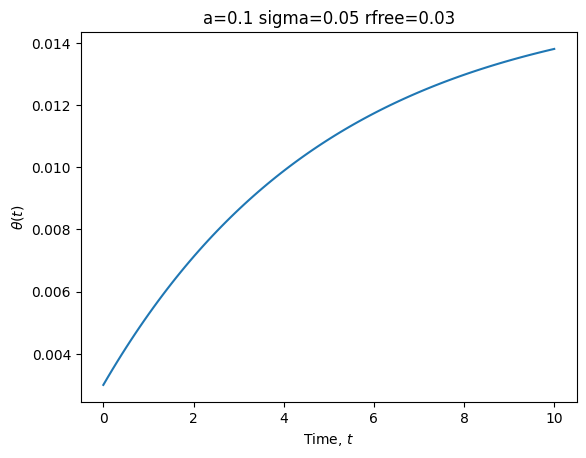

In [16]:
fig, ax = plt.subplots()
ax.plot(model.theta_t, model.theta_y, '-')
ax.set_xlabel('Time, $t$')
ax.set_ylabel('$\\theta(t)$')
ax.set_title(f'a={model.a_const} sigma={model.sigma_const} rfree={model.rfree_const}')
plt.show()

In [17]:
histograms_for_states = [model.rate, model.df, model.fdf]

for t in [model.TimeHorizon/2,model.TimeHorizon]:
    eval_point = sdk.EvaluationPoint(t)
    for h in histograms_for_states:
        eval_point.Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                h.GetStateNumber(),
                200
            ),
        ))                
    model.evaluations.append(eval_point)

In [18]:
results = sdk.run (model, server)
results.df()

,name,title,state,point,time,step,npaths,mean,mean_error,stddev,skewness
0,Polynom,a=0.1,0,0,5.0,49,100000,0.100000,0.000000e+00,0.000000,0.000000
1,Polynom,sigma=0.05,1,0,5.0,49,100000,0.050000,0.000000e+00,0.000000,0.000000
2,Linear1DInterpolation,theta(t),2,0,5.0,49,100000,0.010901,0.000000e+00,0.000000,0.000000
3,HullWhite1FactorModel,rate,3,0,5.0,49,100000,0.049144,2.822406e-04,0.089252,-0.007448
4,ZeroCouponBond,discount factor,4,0,5.0,49,100000,0.859985,7.389118e-04,0.233664,0.804094
5,ForwardZeroCouponBond,"forward discount factor P(0,5.0,10)",5,0,5.0,49,100000,0.797848,1.177436e-03,0.372338,1.485554
6,Polynom,a=0.1,0,1,10.0,99,100000,0.100000,0.000000e+00,0.000000,0.000000
7,Polynom,sigma=0.05,1,1,10.0,99,100000,0.050000,0.000000e+00,0.000000,0.000000
8,Linear1DInterpolation,theta(t),2,1,10.0,99,100000,0.013808,2.209561e-08,0.000007,-4149.687500
9,HullWhite1FactorModel,rate,3,1,10.0,99,100000,0.079777,3.292067e-04,0.104104,-0.009140


### Compare analyticaly and MC computed rate (mean,stddev)

In [19]:
pd.DataFrame([{
    'Method':'Theory',
    f'mean: r(T={model.T[0]})':model.rate_gaussian[0][0],
    f'stddev: r(T={model.T[0]})':math.sqrt(model.rate_gaussian[0][1]),
    f'mean: r(T={model.T[1]})':model.rate_gaussian[1][0],
    f'stddev: r(T={model.T[1]})':math.sqrt(model.rate_gaussian[1][1])
},{
    'Method':'MonteCarlo',
    f'mean: r(T={model.T[0]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),0).mean,
    f'stddev: r(T={model.T[0]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),0).stddev,
    f'mean: r(T={model.T[1]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),1).mean,
    f'stddev: r(T={model.T[1]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),1).stddev
}])

,Method,mean: r(T=5.0),stddev: r(T=5.0),mean: r(T=10),stddev: r(T=10)
0,Theory,0.049352,0.088890,0.079947,0.103963
1,MonteCarlo,0.049144,0.089252,0.079777,0.104104


### Compare analyticaly and MC computed expected bond value

In [20]:
hw = model.hw_analytical
#hw.P_lambdify()(hw.a,hw.sigma,hw.r,hw.t)
hw.P()

In [21]:
Plambda = lambdify([hw.a,hw.sigma,hw.r,hw.t,hw.T],hw.P())
P = lambda t: Plambda (model.a_const,model.sigma_const,model.rfree_const,0,t)

In [22]:
pd.DataFrame([{
    'Method':'Theory',
    f'mean: P(0,T={model.T[0]})':P(model.T[0]),
    f'mean: P(0,T={model.T[1]})':P(model.T[1]),
},{
    'Method':'MonteCarlo',
    f'mean: P(0,T={model.T[0]})':results.GetStateEvaluationResult(model.df.GetStateNumber(),0).mean,
    f'mean: P(0,T={model.T[1]})':results.GetStateEvaluationResult(model.df.GetStateNumber(),1).mean,
}])

,Method,"mean: P(0,T=5.0)","mean: P(0,T=10)"
0,Theory,0.860708,0.740818
1,MonteCarlo,0.859985,0.739908


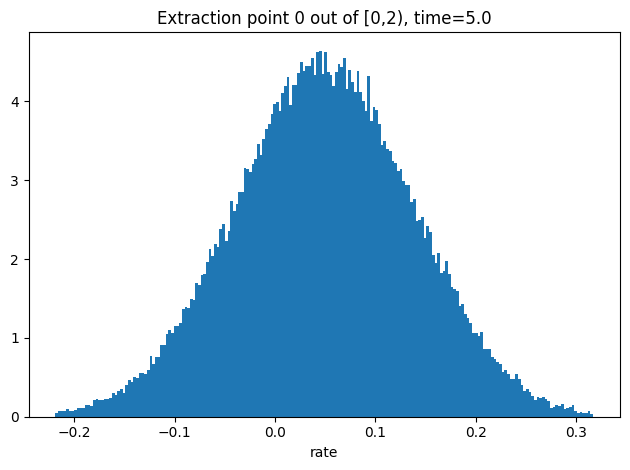

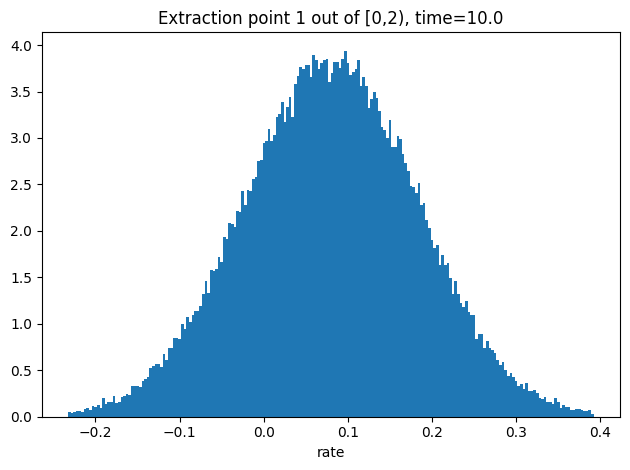

In [23]:
state = model.rate.GetStateNumber()
plot(results=results,point=0,stateX=state)
plot(results=results,point=1,stateX=state)

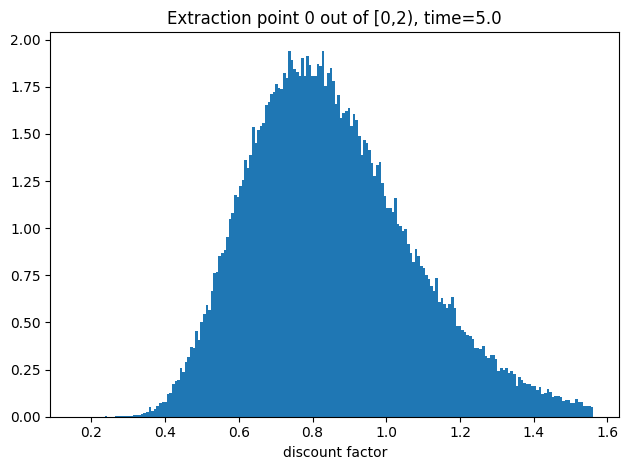

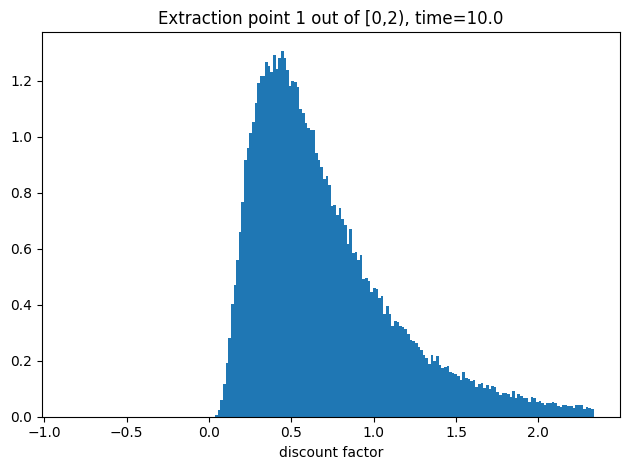

In [24]:
state = model.df.GetStateNumber()
plot(results=results,point=0,stateX=state)
plot(results=results,point=1,stateX=state)